In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('./data/prepared/df_energy_climate_2020.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

<AxesSubplot: title={'center': 'Energy price in 2020'}, xlabel='datetime'>

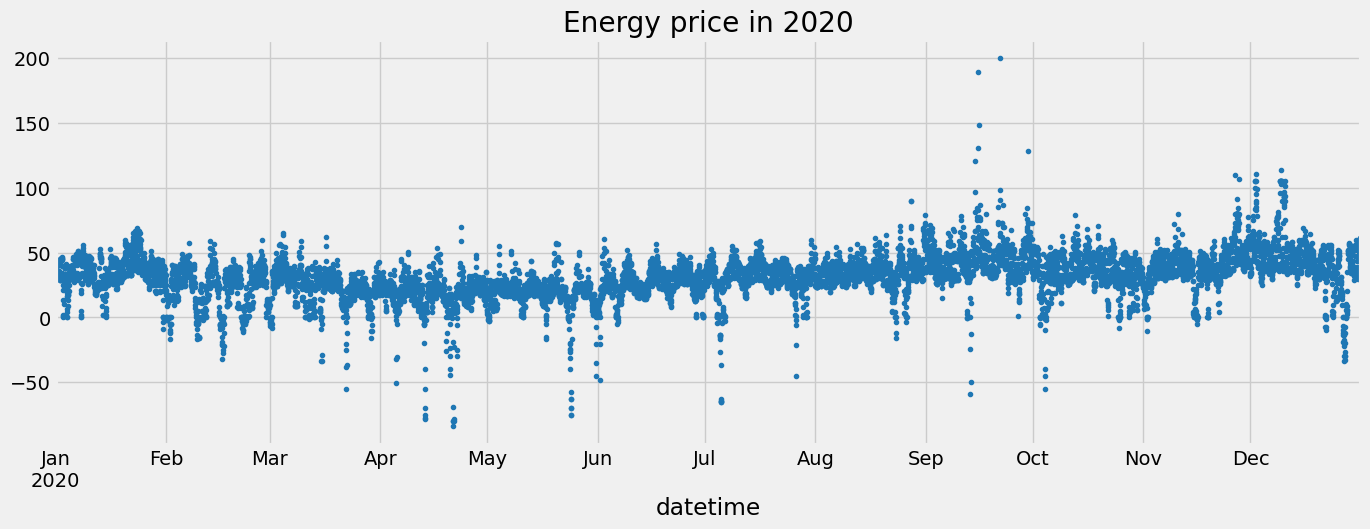

In [3]:
df['energy_price'].plot(
    style='.', 
    figsize=(15, 5),
    color=color_pal[0], # type: ignore
    title='Energy price in 2020'
)

In [4]:
splitting_point = (int(len(df)*0.2))

train, test = df[:-splitting_point], df[-splitting_point:]

In [5]:
df.index[-splitting_point]

Timestamp('2020-10-19 20:00:00')

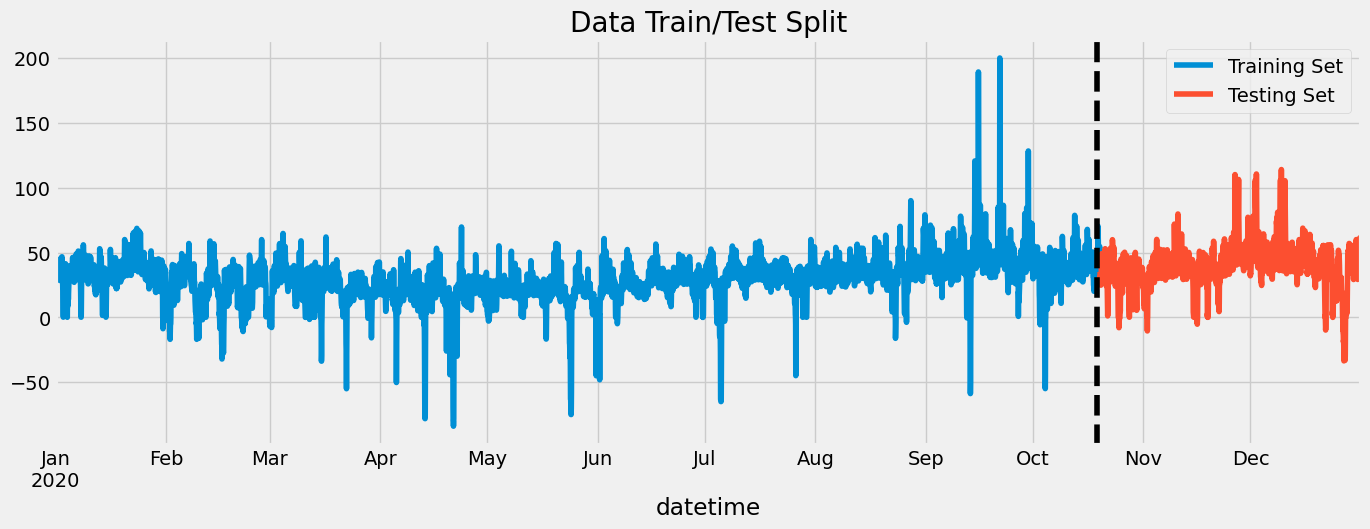

In [6]:
fig, ax = plt.subplots(figsize =(15, 5))
train.plot(ax=ax, y='energy_price', label = 'Training Set', title='Data Train/Test Split')
test.plot(ax=ax, y='energy_price', label = 'Testing Set')
ax.axvline('2020-10-19', color='black', ls='--') # type: ignore
plt.show()

<AxesSubplot: title={'center': 'Week of data'}, xlabel='datetime'>

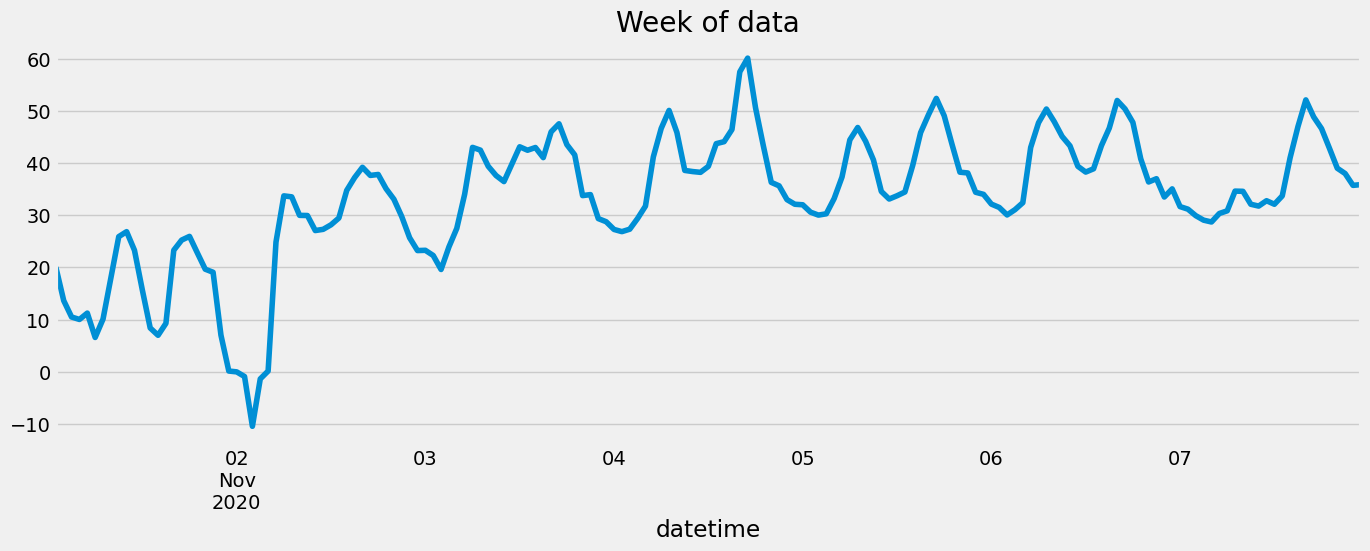

In [7]:
df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['energy_price'].plot(figsize=(15,5), title='Week of data')

In [8]:
FEATURES = ['hour', 'dayofweek', 'month']
TARGET = 'energy_price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [9]:
reg = xgb.XGBRegressor()

## Search for hyperparameters

In [10]:
# make a dictionary of hyperparameter values to search
search_space = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 9],
    'gamma': [0.01, 0.1],
    'learning_rate': [0.001, 0.01, 0.1],
}

GS = GridSearchCV(estimator = reg,
                  param_grid = search_space,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit = 'r2', # type: ignore
                  cv = 5,
                  verbose=4
)

In [11]:
GS.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-30.580) r2: (test=-2.996) total time=   0.1s
[CV 2/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-22.826) r2: (test=-1.087) total time=   0.1s
[CV 3/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-22.494) r2: (test=-2.025) total time=   0.2s
[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-29.913) r2: (test=-4.565) total time=   0.1s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-40.242) r2: (test=-4.310) total time=   0.1s
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-25.496) r2: (test=-1.778) total tim

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'gamma': [0.01, 0.1],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 500, 1000]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=4)

In [12]:
print(GS.best_params_)

{'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


In [13]:
reg = xgb.XGBRegressor(
    gamma=0.01,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=500
)

In [14]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
)

[0]	validation_0-rmse:32.00740	validation_1-rmse:42.73430
[100]	validation_0-rmse:16.79386	validation_1-rmse:22.23874
[200]	validation_0-rmse:12.84260	validation_1-rmse:17.54612
[300]	validation_0-rmse:11.78742	validation_1-rmse:16.36642
[400]	validation_0-rmse:11.32280	validation_1-rmse:15.99089
[499]	validation_0-rmse:11.03981	validation_1-rmse:15.88613


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

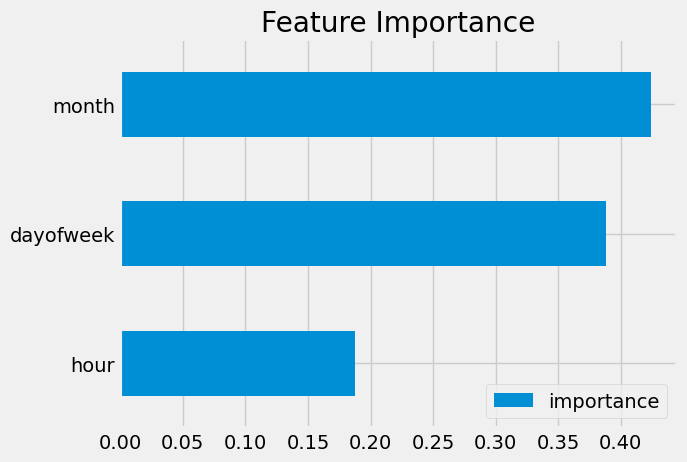

In [15]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance']
)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

/var/folders/cz/cwy65nds1w7_vfh7mtxwrks40000gn/T/ipykernel_5993/3449227081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


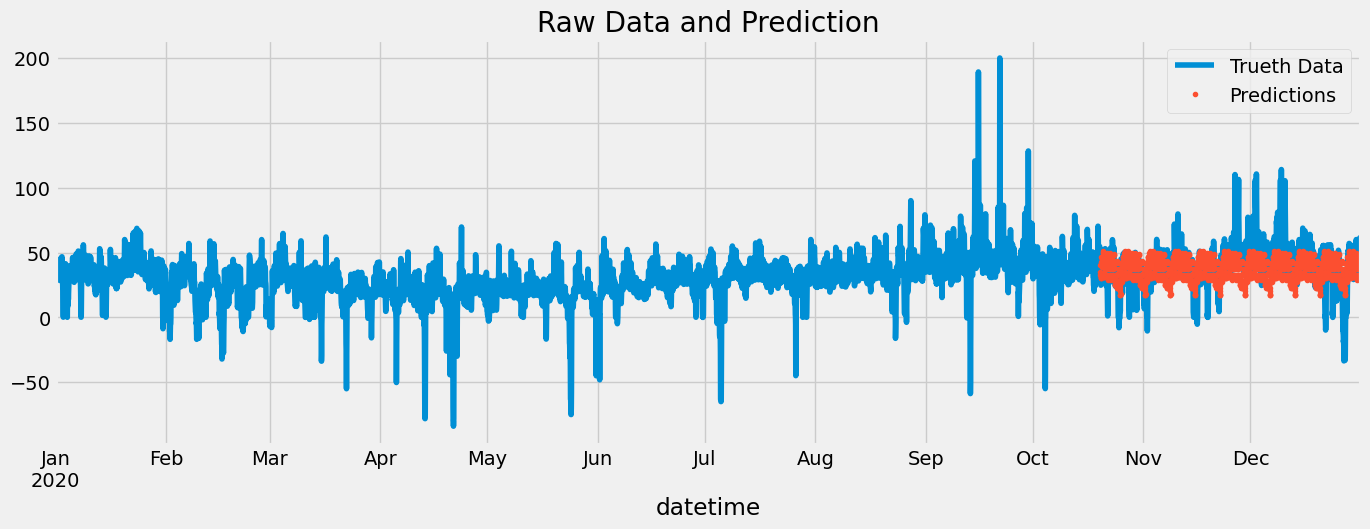

In [16]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['energy_price']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Trueth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

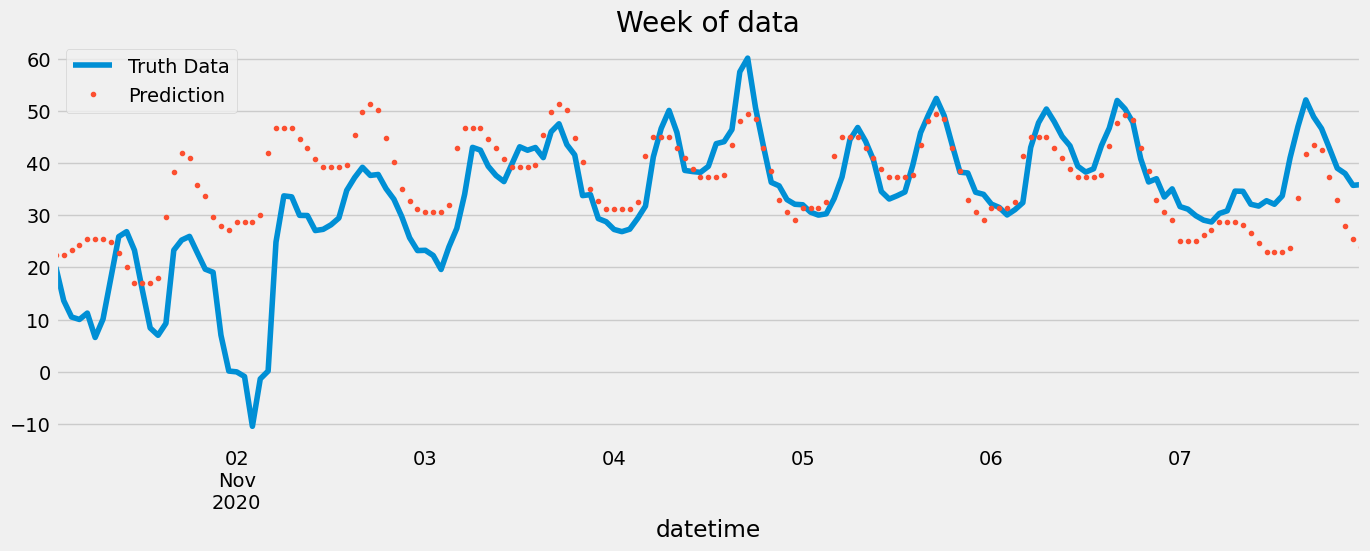

In [17]:
ax = df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['energy_price'].plot(figsize=(15,5), title='Week of data')
df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [18]:
score_rmse = np.sqrt(mean_squared_error(test['energy_price'], test['prediction']))
print(f'RMSE Score on test set: {score_rmse:.2f}')
score_mape = (mean_absolute_percentage_error(test['energy_price'], test['prediction']))
print(f'MAPE Score on test set: {score_mape:.2f}')

RMSE Score on test set: 15.89
MAPE Score on test set: 12.59


<AxesSubplot: ylabel='Frequency'>

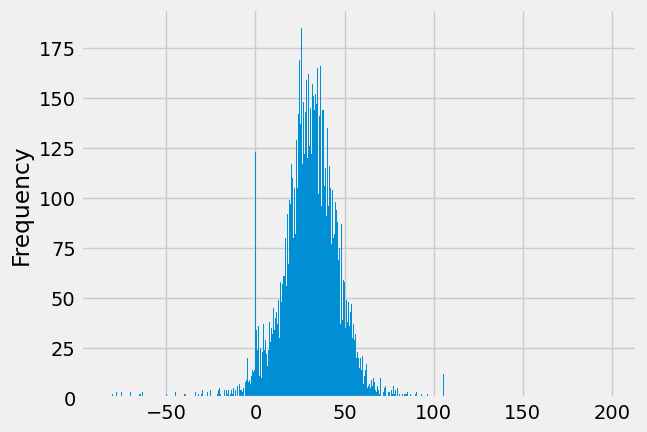

In [19]:
df['energy_price'].plot(kind='hist', bins=500)

<AxesSubplot: xlabel='datetime'>

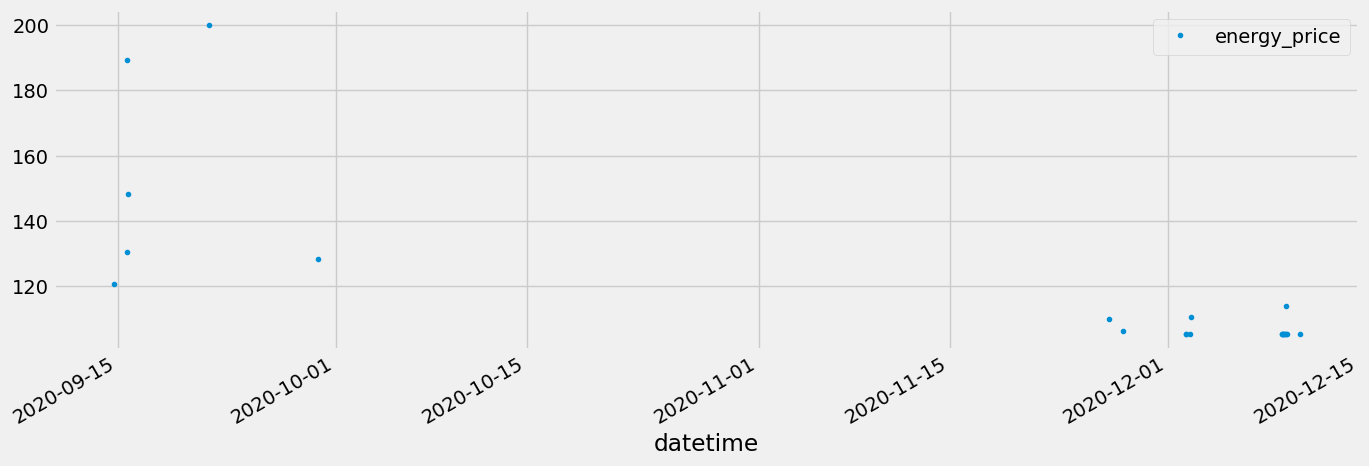

In [20]:
df.query('energy_price > 105').plot(y='energy_price', figsize=(15, 5), style='.')

<AxesSubplot: xlabel='datetime'>

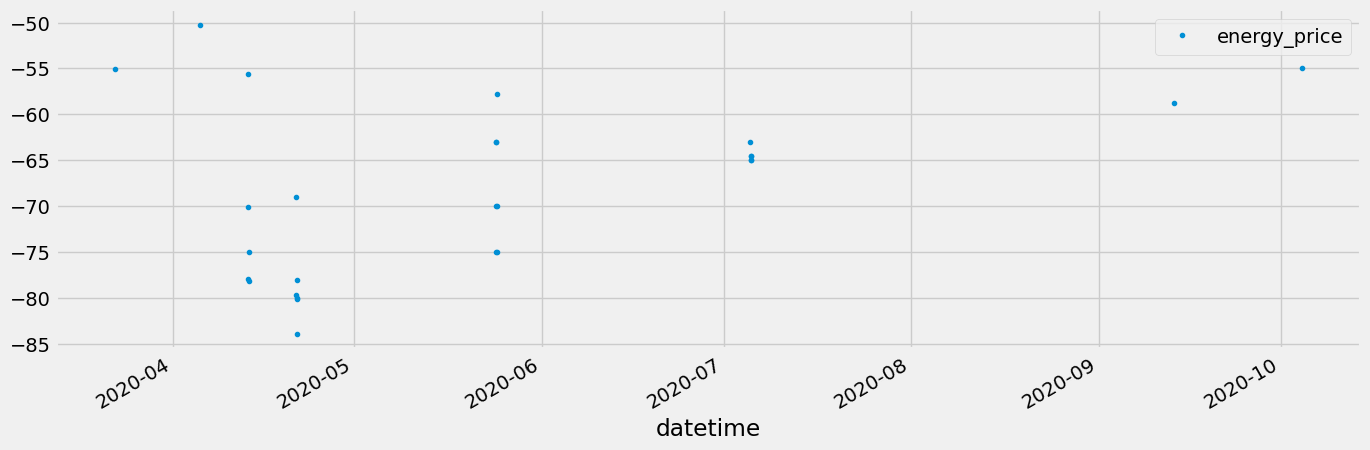

In [21]:
df.query('energy_price < -50').plot(y='energy_price', figsize=(15, 5), style='.')

In [22]:
df = df.query('energy_price < 105').copy()

In [23]:
df = df.query('energy_price > -50').copy()

In [24]:
tss = TimeSeriesSplit(n_splits=5, test_size=168)
df = df.sort_index()

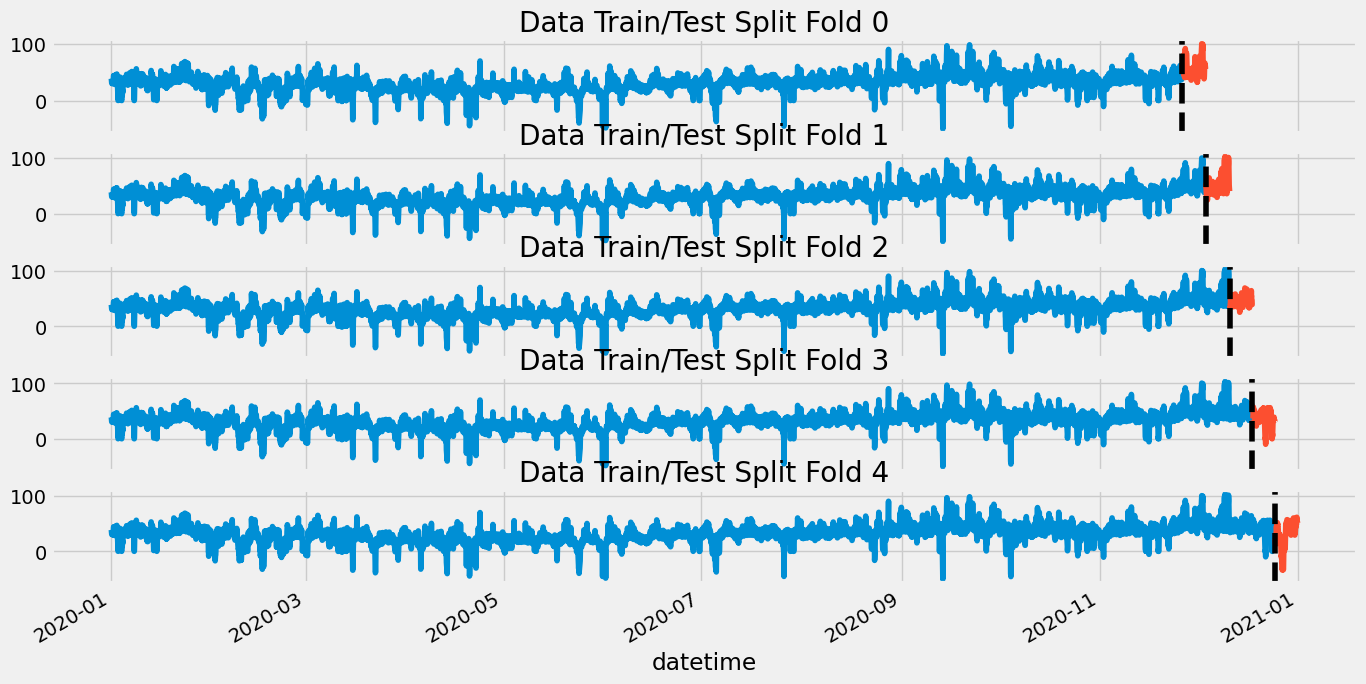

In [25]:
fig, axs = plt.subplots(5, 1, figsize=(15, 8), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['energy_price'].plot(ax=axs[fold],
                               label='Training Set',
                               title=f'Data Train/Test Split Fold {fold}')
    test['energy_price'].plot(ax=axs[fold],
                              label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold +=1

In [26]:
def add_lags(df):
    target_map = df['energy_price'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('1 day')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1 hour')).map(target_map)
    return df

In [27]:
df = add_lags(df)

In [28]:
tss = TimeSeriesSplit(n_splits=5, test_size=168)
df = df.sort_index()

fold = 0
preds = []
scores_rmse = []
scores_mape = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['month', 'hour', 'dayofweek']
    TARGET = 'energy_price'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        early_stopping_rounds=50,
        objective='reg:linear',
        max_depth=3,
        learning_rate=0.01
    )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores_rmse.append(score_rmse)
    score_mape = (mean_absolute_percentage_error(y_test, y_pred))
    scores_mape.append(score_mape)

[22:16:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.07059	validation_1-rmse:55.73218
[99]	validation_0-rmse:15.88011	validation_1-rmse:33.73887
[22:16:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.73522	validation_1-rmse:52.62905
[99]	validation_0-rmse:16.22515	validation_1-rmse:30.22290
[22:16:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.25753	validation_1-rmse:46.08576
[99]	validation_0-rmse:16.48395	validation_1-rmse:1

In [29]:
print(f'RMSE scores across folds {np.mean(scores_rmse):.4f}')
print(f'Fold RMSE scores: {scores_rmse}')
print(f'MAPE scores across folds {np.mean(scores_mape):.4f}')
print(f'Fold MAPE scores: {scores_mape}')

RMSE scores across folds 23.8910
Fold RMSE scores: [33.738872246691244, 30.22290124572533, 18.346076708666853, 14.468813049193015, 22.678263638899473]
MAPE scores across folds 7.3390
Fold MAPE scores: [0.5622526060836496, 0.4743075605473883, 0.36010285913318946, 16.109647522015898, 19.188802801910814]


In [30]:
tss = TimeSeriesSplit(n_splits=5, test_size=168)
df = df.sort_index()

fold = 0
preds = []
scores_rmse = []
scores_mape = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['month', 'hour', 'dayofweek', 'lag1', 'lag2', 'lag3']
    TARGET = 'energy_price'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        early_stopping_rounds=50,
        objective='reg:linear',
        max_depth=3,
        learning_rate=0.01
    )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores_rmse.append(score_rmse)
    score_mape = (mean_absolute_percentage_error(y_test, y_pred))
    scores_mape.append(score_mape)

[22:16:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.03943	validation_1-rmse:55.60708
[99]	validation_0-rmse:12.90248	validation_1-rmse:25.85937
[22:16:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.70247	validation_1-rmse:52.54623
[99]	validation_0-rmse:13.24923	validation_1-rmse:24.56136
[22:16:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.22444	validation_1-rmse:46.02327
[99]	validation_0-rmse:13.49659	validation_1-rmse:1

In [31]:
print(f'RMSE scores across folds {np.mean(scores_rmse):.4f}')
print(f'Fold RMSE scores: {scores_rmse}')
print(f'MAPE scores across folds {np.mean(scores_mape):.4f}')
print(f'Fold MAPE scores: {scores_mape}')

RMSE scores across folds 19.7229
Fold RMSE scores: [25.85936669896662, 24.561356101222895, 17.84146072989099, 14.41351155909656, 15.938651721054761]
MAPE scores across folds 1.3960
Fold MAPE scores: [0.4061502611651413, 0.39169875968255075, 0.3677322271930509, 3.7689838144869037, 2.0453770702352068]


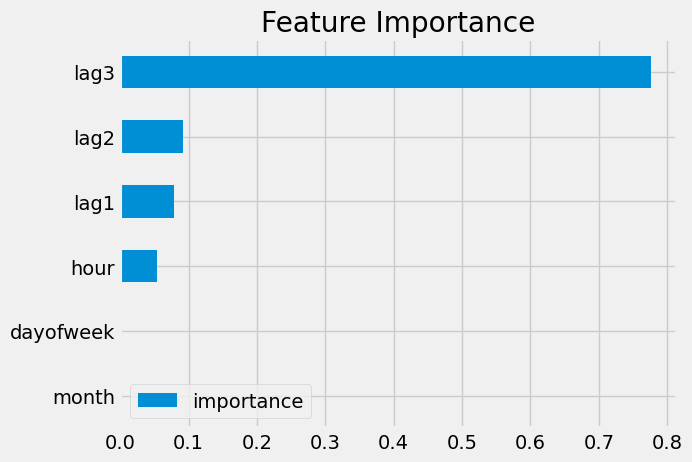

In [32]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance']
)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()